# House price prediction of Beijing


### The Data

The dataset contain the information of house price of Beijing from 2011 to 2017, fetching from Lianjia.com. The dataset is available from https://www.kaggle.com/ruiqurm/lianjia/downloads/lianjia.zip/2. 

Unzip the `new.csv` file (__318851 rows × 26 columns__). This dataset contains detailed information: URL, ID, Lng, Lat, CommunityID, TradeTime, DOM(days on market), Followers, Total price, Price, Square, Living Room, number of Drawing room, Kitchen and Bathroom, Building Type, Construction time. renovation condition, building structure, Ladder ratio( which is the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average), elevator, Property rights for five years（It's related to China restricted purchase of houses policy), Subway, District, Community average price.

Most data is traded in 2011-2017, some of them is traded in Jan,2018, and some is even earlier(2010,2009)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import time
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os
%matplotlib inline

### Reading data
Path is the link to the unzipped csv file.

In [2]:
path=os.getcwd()

In [3]:
file_path=path+'/Dataset/new.csv'
data=pd.read_csv(file_path,encoding = 'unicode_escape')
print('The dataset is of row {:d} and column {:d}.'.format(data.shape[0],data.shape[1]))

The dataset is of row 318851 and column 26.


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


### Data cleanup
The process involves romoving duplicated building, dropping out unwanted columns, transforming time and clean up unformated data by introducing customed function such as __convert_floor__. Dataset was enriched by introducing extra column like buliding age years which can be obtained through exist two columns. The dataset then was specified in the Beijing centre area through exploring the latitude and longnitude. The trade time subset from 2014-1016 (price stable period) was choseen to investigate the other parameters effect.

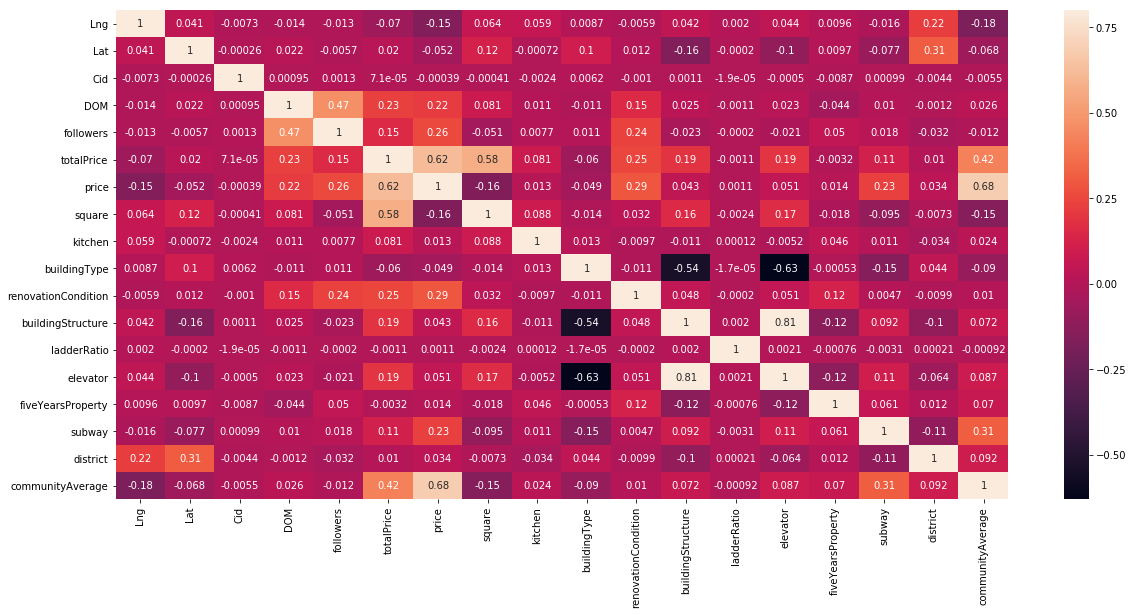

In [5]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

In [6]:
#Remove duplicated id building
data = data.drop_duplicates(subset='id')
print('The dataset is of row {:d} and column {:d}.'.format(data.shape[0],data.shape[1]))

The dataset is of row 318851 and column 26.


In [9]:
#Drop unwanted columns for low correlated feature; 'url,id,Cid,ladderRatio,fiveYearsProperty'
#DOM'  of much null value ; 
#The 'totalprice' is replicated information for the price
to_drop = ['url',
           'id',
           'Cid',
           'ladderRatio',
           'fiveYearsProperty',
           'DOM',
           'totalPrice',
          ]
data.drop(to_drop, inplace=True, axis=1)

In [10]:
data.isnull().sum()

Lng                        0
Lat                        0
tradeTime                  0
followers                  0
price                      0
square                     0
livingRoom                 0
drawingRoom                0
kitchen                    0
bathRoom                   0
floor                      0
buildingType            2021
constructionTime       19315
renovationCondition        0
buildingStructure          0
elevator                  32
subway                    32
district                   0
communityAverage         463
building_age_years     19315
dtype: int64

In [11]:
data=data[data['floor'].notnull()]
data=data[data['constructionTime'].notnull()]
data=data[data['communityAverage'].notnull()]
data=data[data['buildingType'].notnull()]
data.isnull().sum()

Lng                    0
Lat                    0
tradeTime              0
followers              0
price                  0
square                 0
livingRoom             0
drawingRoom            0
kitchen                0
bathRoom               0
floor                  0
buildingType           0
constructionTime       0
renovationCondition    0
buildingStructure      0
elevator               0
subway                 0
district               0
communityAverage       0
building_age_years     0
dtype: int64

In [12]:
# Transforming tradetime and constructionTime column into datetime object so as to be manipulated easier. 
#The building age year is created by substracting the tradetime to construction time. 
data['tradeTime'] =pd.to_datetime(data['tradeTime'])
data['constructionTime'] =data['constructionTime'].str.extract(r'^(\d{4})', expand=False)

In [13]:
#The building age can be obtained by tradetime and construction time
data['building_age_years']=(data['tradeTime']-pd.to_datetime(data['constructionTime']))
def get_year(d):
    return float(str(d).split(' ')[0])/365
data['building_age_years']=data['building_age_years'].apply(get_year)

In [14]:
def convert_floor(d):
    try:
        return int(d.split(' ')[-1])
    except ValueError:
        pass
def convert_room(d):
    try:
        return int(d)
    except ValueError:
        pass
data['floor']=data['floor'].apply(convert_floor)
data['livingRoom']=data['livingRoom'].apply(convert_room)
data['drawingRoom']=data['drawingRoom'].apply(convert_room)
data['kitchen']=data['kitchen'].apply(convert_room)
data['bathRoom']=data['bathRoom'].apply(convert_room)


In [15]:
data.describe()

,Lng,Lat,followers,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,buildingStructure,elevator,subway,district,communityAverage,building_age_years
count,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.00000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000,297701.000000
mean,116.418608,39.949769,17.169667,43820.549521,82.681580,2.011223,1.171370,0.994639,1.182495,13.166200,3.028962,2.61634,4.421346,0.570714,0.602024,6.751664,63688.935949,16.129417
std,0.111230,0.091511,34.740228,21789.623587,35.730446,0.764842,0.512374,0.102725,0.422909,7.761751,1.265519,1.30700,1.907762,0.494975,0.489481,2.813745,22167.552976,8.858026
min,116.072514,39.627030,0.000000,1.000000,7.370000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,10847.000000,-6.591781
25%,116.345810,39.893200,0.000000,28224.000000,57.930000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.00000,2.000000,0.000000,0.000000,6.000000,46505.000000,9.463014
50%,116.416780,39.934530,5.000000,39033.000000,74.000000,2.000000,1.000000,1.000000,1.000000,11.000000,4.000000,3.00000,6.000000,1.000000,1.000000,7.000000,59025.000000,14.035616
75%,116.476921,40.003156,19.000000,54249.000000,98.320000,2.000000,1.000000,1.000000,1.000000,19.000000,4.000000,4.00000,6.000000,1.000000,1.000000,8.000000,75858.000000,21.772603
max,116.711337,40.252758,1143.000000,150000.000000,640.000000,8.000000,5.000000,3.000000,7.000000,63.000000,4.000000,4.00000,6.000000,1.000000,1.000000,13.000000,183109.000000,67.602740


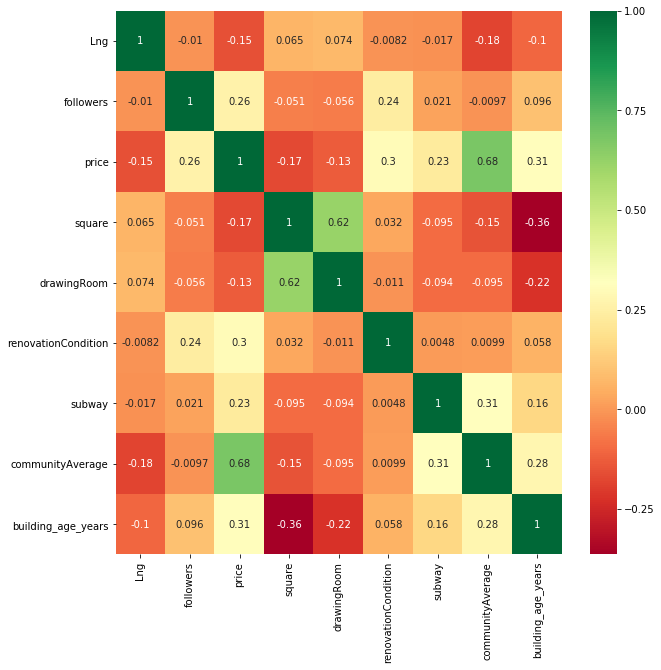

In [16]:
# most correlated features
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["price"])>0.1]
plt.figure(figsize=(10,10))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

*Note:CommunityAverage is highly corrected with target feature price.*

<Figure size 720x720 with 0 Axes>

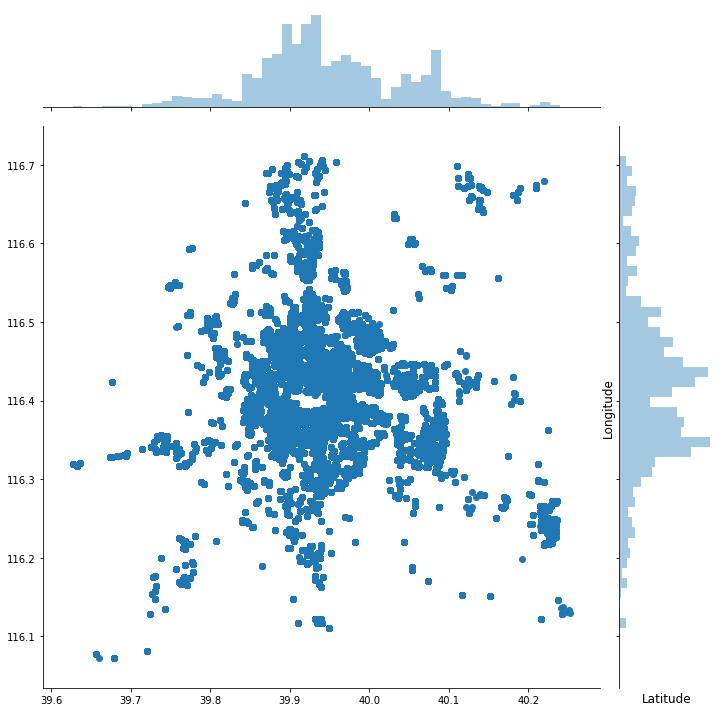

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [17]:
plt.figure(figsize=(10,10))
sns.jointplot(x=data.Lat.values, y=data.Lng.values, height=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
sns.despine

Note: It can be seen that the data is concentrated in the area where the longitude is between 39.8 to 40.05 and the latitude is between 116.25 to 116.5. This area is Beijing centre area. 

In [18]:
#obtain the centre area dataset
data_centre=data.loc[(data.Lng >116.25) & (data.Lng <116.5)& (data.Lat <40.05)& (data.Lat <39.8)]

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price against year')

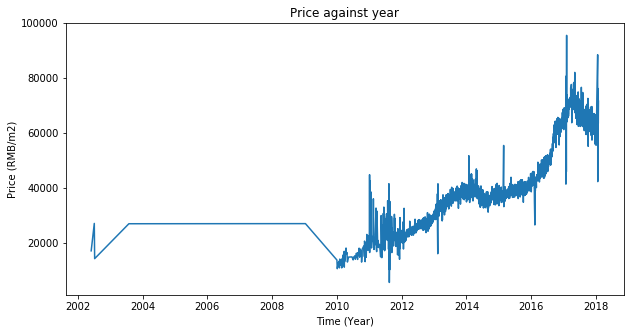

In [19]:
#explore the time effect
plt.figure(figsize=(10,5))
price_date=data.groupby(['tradeTime'])['price'].mean().reset_index()
plt.plot(price_date['tradeTime'],price_date['price'])
plt.xlabel('Time (Year)')
plt.ylabel('Price (RMB/m2)')
plt.title('Price against year')

Note: It can show that the price is relatively stable between 2014 to 2016. To further explore the other parameter's effect, the data between 2014 to 2016 was chosen to fit the model. 

In [20]:
#Prepare the dataset from 2014 to 2016
data_centre_2014_2016=data_centre.loc[(data_centre.tradeTime >pd.Timestamp('2014-01-01')) & (data_centre.tradeTime <pd.Timestamp('2016-01-01'))]


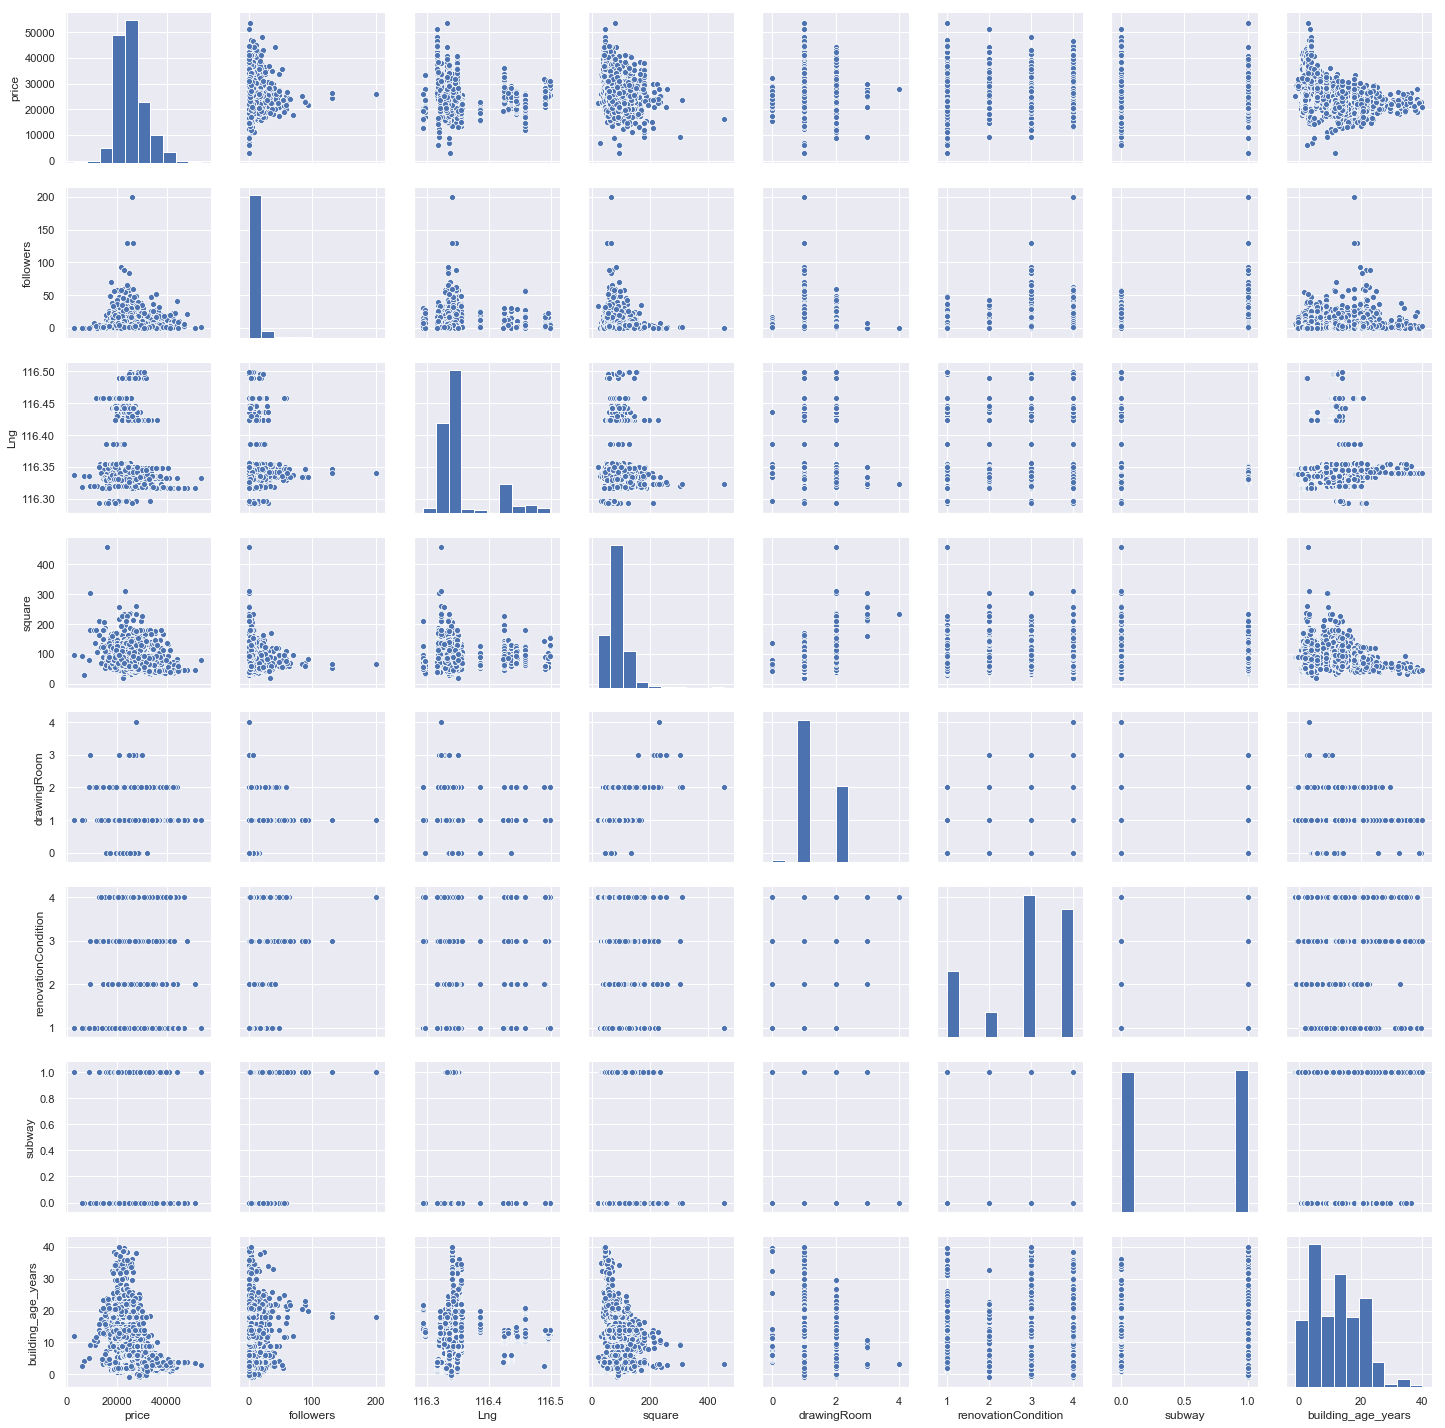

In [21]:
sns.set()
cols = ['price', 'followers', 'Lng', 'square', 'drawingRoom', 'renovationCondition', 'subway','building_age_years']
sns.pairplot(data_centre_2014_2016[cols], height = 2.5)
plt.show();

### Target feature analysis


 mu = 25736.28 and sigma = 5665.31



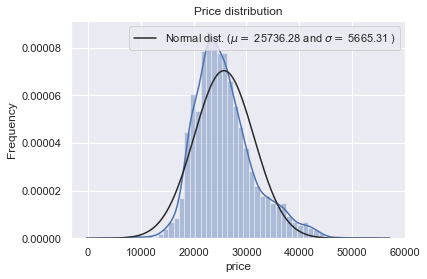

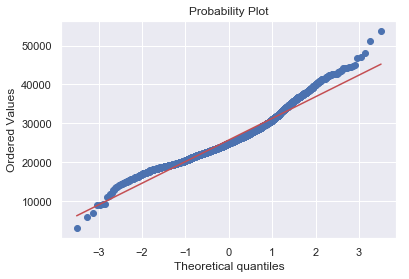

In [22]:
from scipy import stats
from scipy.stats import norm,skew
sns.distplot(data_centre_2014_2016['price'],fit=norm)
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_centre_2014_2016['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(data_centre_2014_2016['price'], plot=plt)
plt.show()

In [23]:
data_centre_2014_2016.price = np.log1p(data_centre_2014_2016.price )

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [24]:
print("Find most important features relative to target")
corr = data_centre_2014_2016.corr()
corr.sort_values(["price"], ascending = False, inplace = True)
print(corr.price)

Find most important features relative to target
price                  1.000000
communityAverage       0.782654
elevator               0.483090
buildingStructure      0.469529
floor                  0.406916
Lat                    0.355066
bathRoom               0.185267
drawingRoom            0.175027
district               0.029163
renovationCondition    0.003594
subway                -0.012624
followers             -0.021569
kitchen               -0.026518
livingRoom            -0.030259
square                -0.100296
Lng                   -0.175812
buildingType          -0.200559
building_age_years    -0.491404
Name: price, dtype: float64


### Training time

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
#Prepare the feature matrix and result matrix
x=data_centre_2014_2016[['Lng','Lat','communityAverage','square','drawingRoom','livingRoom','kitchen','bathRoom','followers','floor','renovationCondition','elevator','subway','district','building_age_years','buildingType']]
y=data_centre_2014_2016['price']
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=6)

In [27]:
#Define cross_val_score function for both train and test sets separately
n_folds = 5
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x.values)
    rmse = np.sqrt(-cross_val_score(model,x_train,y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x.values)
    rmse = np.sqrt(-cross_val_score(model,x_test,y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

In [28]:
lr = LinearRegression()
lr.fit(x_train,y_train)
test_pre = lr.predict(x_test)
train_pre = lr.predict(x_train)
print('rmse on train',rmse_CV_train(lr).mean())
print('rmse on train',rmse_CV_test(lr).mean())

rmse on train 0.1197797100137685
rmse on train 0.1659653682959558


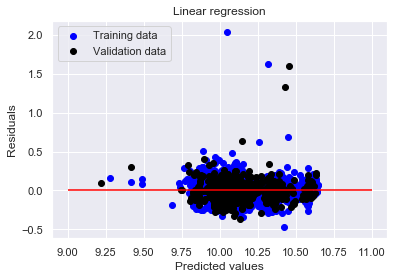

In [29]:
#plot between predicted values and residuals
plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 9, xmax = 11, color = "red")
plt.show()

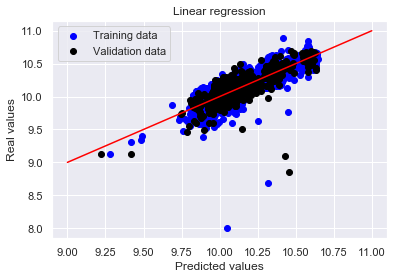

In [30]:
# Plot predictions - Real values
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([9, 11], [9, 11], c = "red")
plt.show()

In [31]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(x_train,y_train)
alpha = ridge.alpha_
print('best alpha',alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],cv = 5)
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)
print("Ridge RMSE on Training set :", rmse_CV_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_CV_test(ridge).mean())
y_train_rdg = ridge.predict(x_train)
y_test_rdg = ridge.predict(x_test)

best alpha 0.03
Try again for more precision with alphas centered around 0.03
Best alpha : 0.020999999999999998
Ridge RMSE on Training set : 0.11977352285299488


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Ridge RMSE on Test set : 0.16540605363317437


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


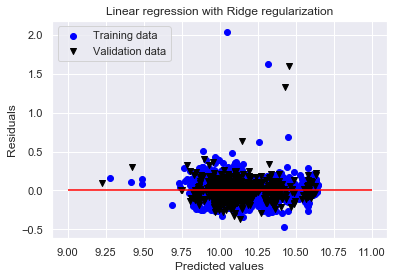

In [32]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue",  label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 9, xmax = 11, color = "red")
plt.show()

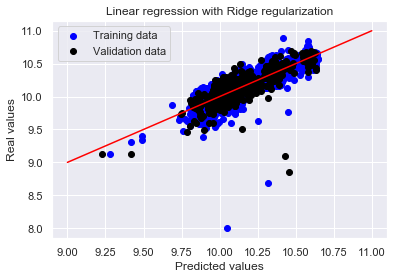

In [33]:
# Plot predictions - Real values
plt.scatter(y_train_rdg, y_train, c = "blue",  label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([9, 11], [9, 11], c = "red")
plt.show()